In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import tensorflow as tf
import tie.recommender
from tie.recommender import Recommender, FactorizationRecommender, BPRRecommender, ImplicitBPRRecommender, WalsRecommender, ImplicitWalsRecommender, TopItemsRecommender
from tie.matrix_builder import ReportTechniqueMatrixBuilder
from tie.engine import TechniqueInferenceEngine
from tie.constants import PredictionMethod
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt
import json

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(tie.recommender)


2024-07-18 11:00:01.252369: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 11:00:01.252701: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 11:00:01.255211: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 11:00:01.287622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 11:00:01.867428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

<module 'tie.recommender' from '/home/mjturner/code/technique-inference-engine/src/tie/recommender/__init__.py'>

In [2]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../data/stix/enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
training_data, test_data, validation_data = data_builder.build_train_test_validation(test_ratio, validation_ratio)

print("Num training interactions", training_data.to_numpy().sum())
print("Num test interactions", test_data.to_numpy().sum())
print("Num validation interactions", validation_data.to_numpy().sum())

Num training interactions 33311.0
Num test interactions 9517.0
Num validation interactions 4758.0


In [11]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}

In [4]:

def test_multiple_embeding_dimensions(model_class: Recommender, method: PredictionMethod, out_file: str, **kwargs):
    """Runs model_class at multiple embedding dimensions and saves results.

    Runs each model for embedding dimensions 4, 8, 10, 16, 32, and 64.

    Args:
        model_class: A model on which to train at multiple embedding dimensions.
        out_file: filename for saving the results file.  Requires len(out_file) > 0
            and out_file is a valid csv filename.
        kwargs: Parameters mapped to values.

    Mutates:
        Saves model results, including embedding_dimension, hyperparameters,
        and precision, recall, and ndcg at 10, 20, 50, and 100 to out_file.
    """
    assert len(out_file) > 0

    results = []

    embedding_dimensions = (4,8,10,16,32,64)
    # for every embedding
    for embedding_dimension in embedding_dimensions:

        # make model
        model = model_class(
            m=training_data.m,
            n=training_data.n,
            k=embedding_dimension,
        )

        # make tie
        tie = TechniqueInferenceEngine(
            training_data=training_data,
            validation_data=validation_data,
            test_data=test_data,
            model=model,
            prediction_method=method,
            enterprise_attack_filepath=enterprise_attack_filepath,
        )

        # fit hyperparameters
        best_hyperparameters = tie.fit_with_validation(**kwargs)

        # calculate precision, recall, ndcg
        run_stats = {
            "embedding_dimension": embedding_dimension,
            **best_hyperparameters
        }
        k_values = (10, 20, 50, 100)
        for k in k_values:
            run_stats[f"precision_at_{k}"] = tie.precision(k=k)
            run_stats[f"recall_at_{k}"] = tie.recall(k=k)
            run_stats[f"ndcg_at_{k}"] = tie.normalized_discounted_cumulative_gain(k=k)

        print(run_stats)
        results.append(run_stats)


    # save as csv
    results_dataframe = pd.DataFrame(results)
    results_dataframe.to_csv(out_file)

2024-07-18 11:00:56.954876: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


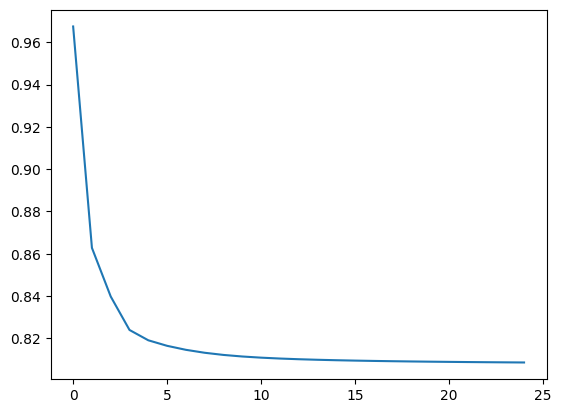

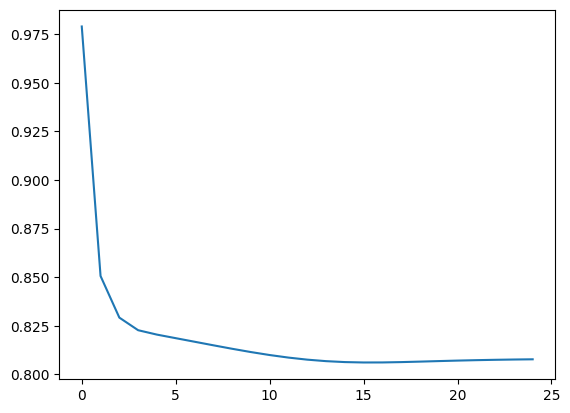

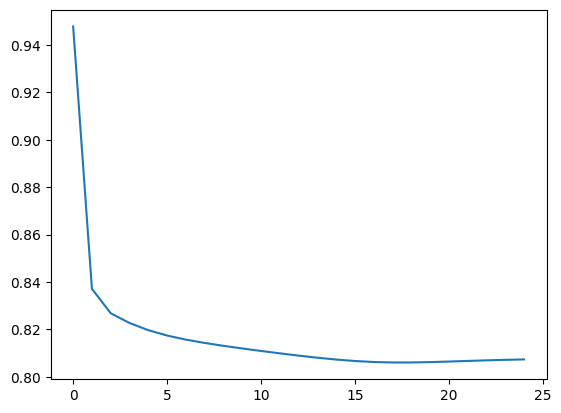

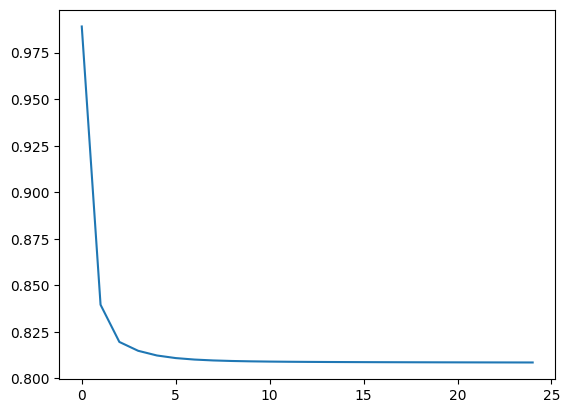

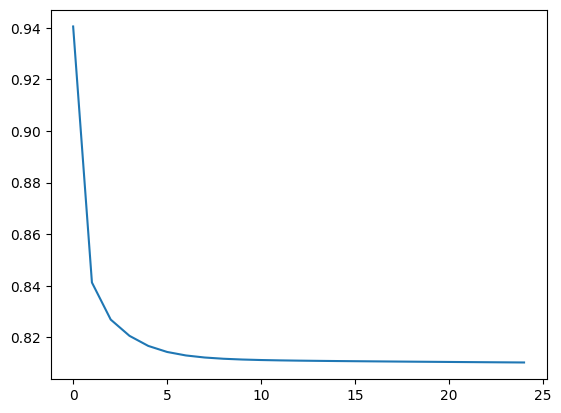

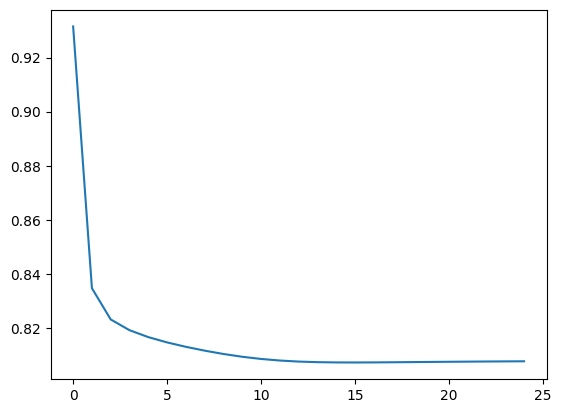

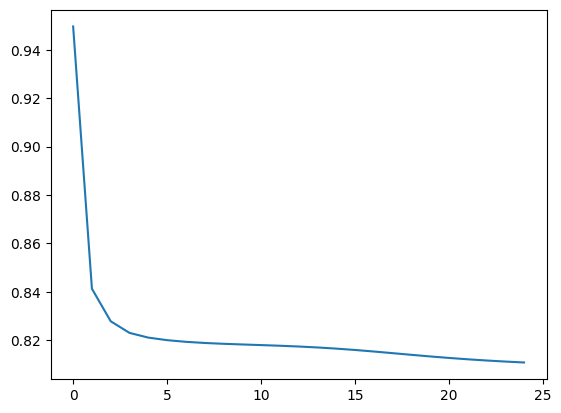

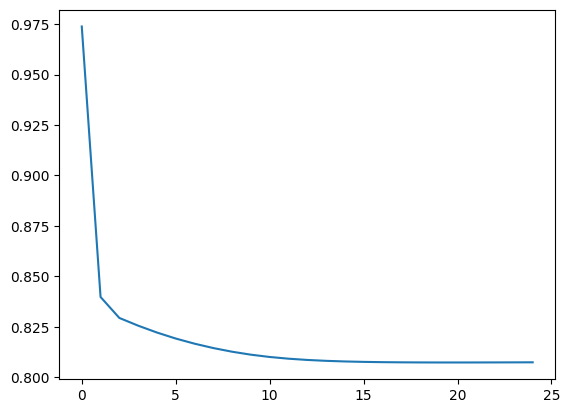

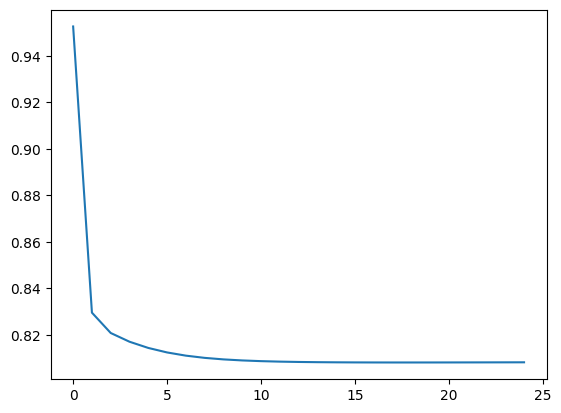

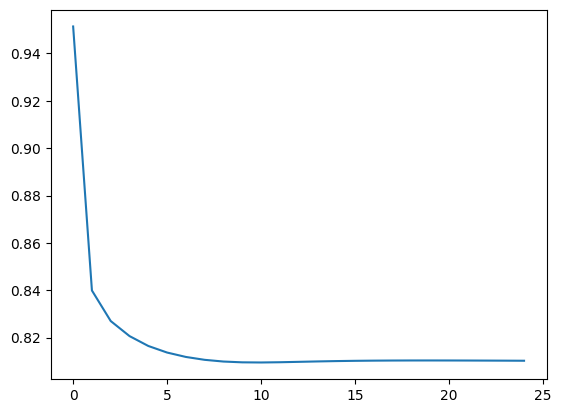

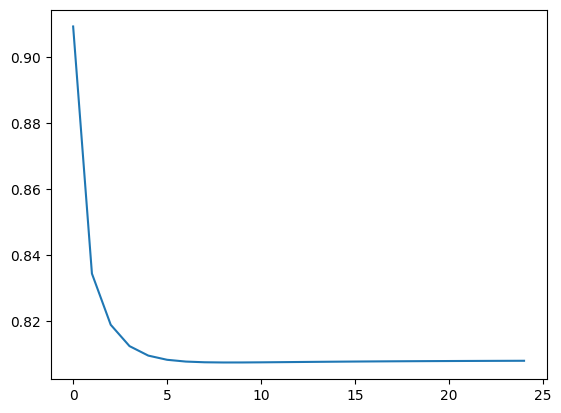

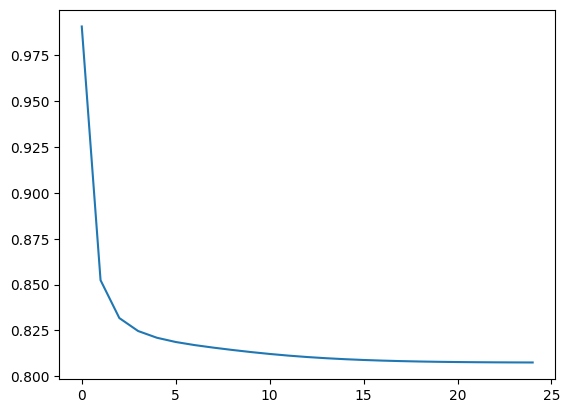

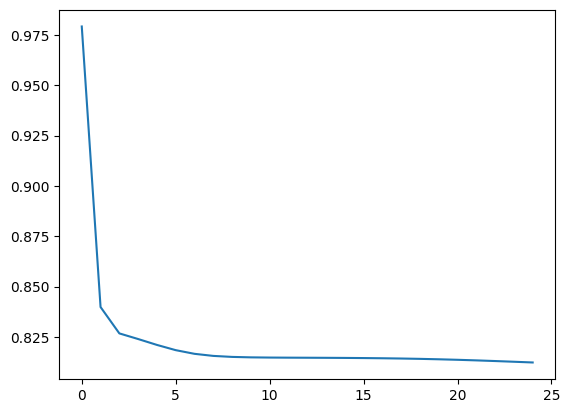

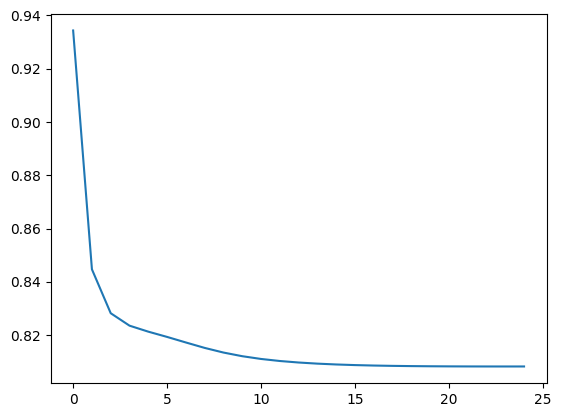

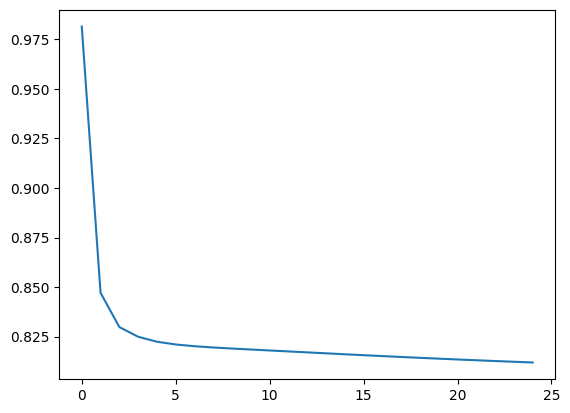

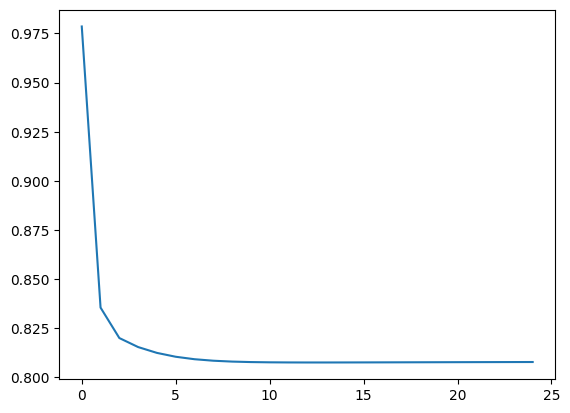

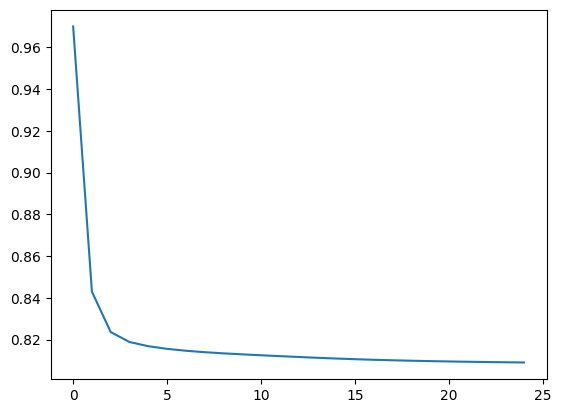

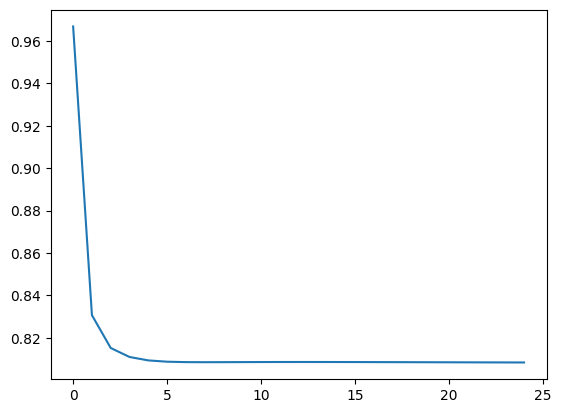

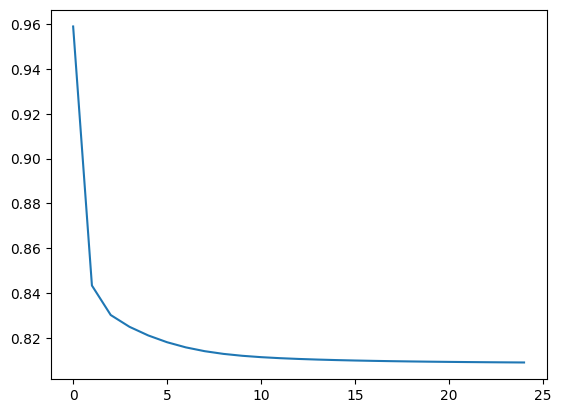

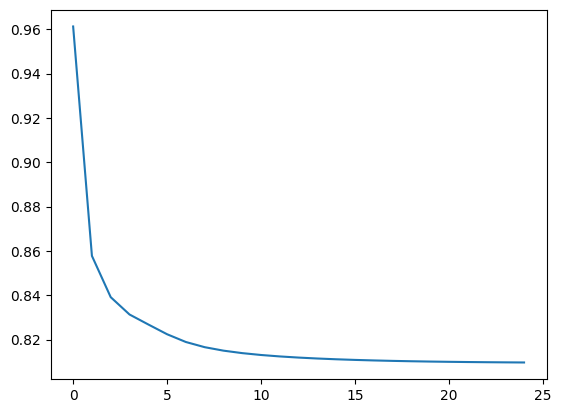

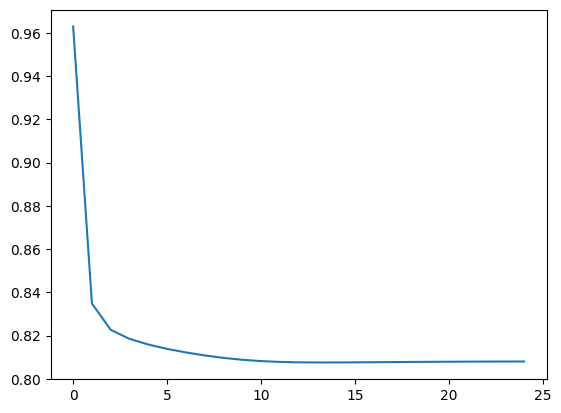

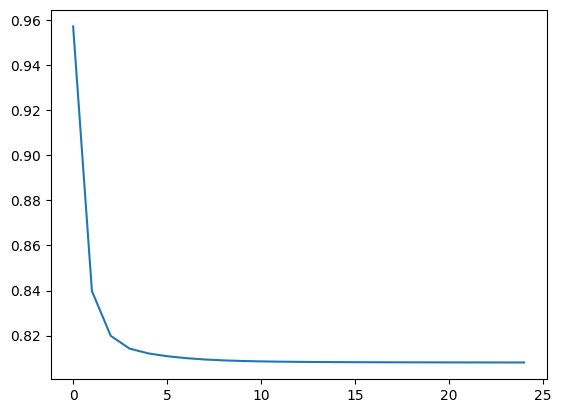

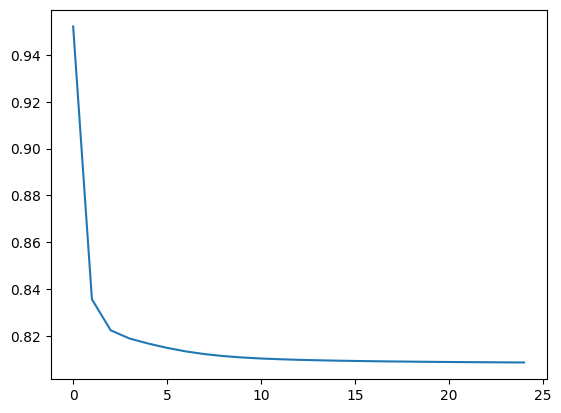

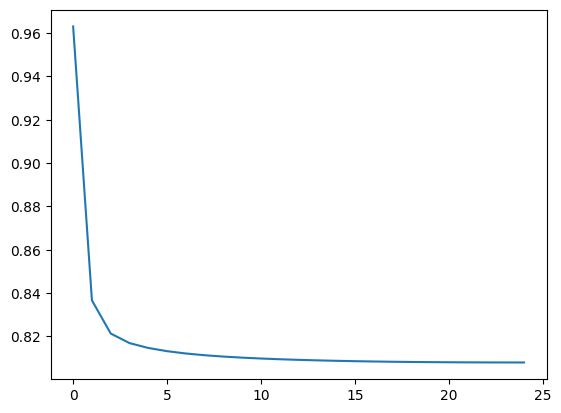

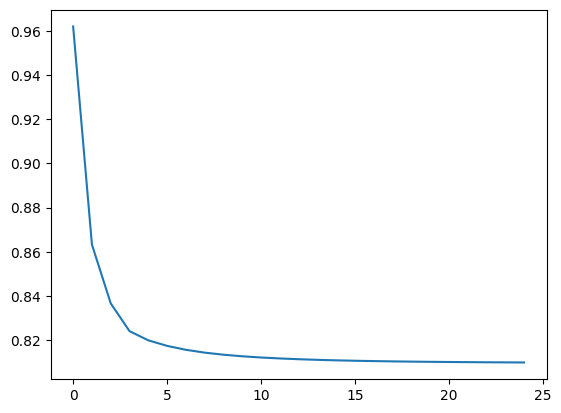

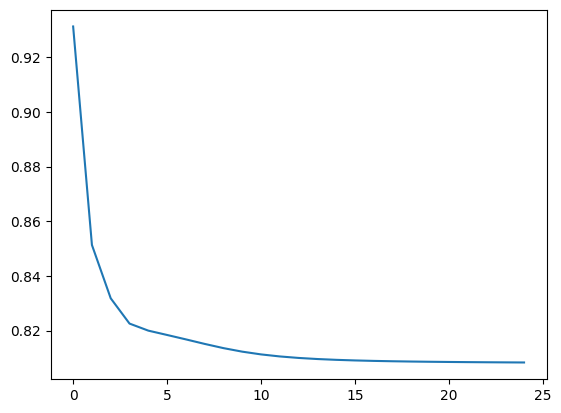

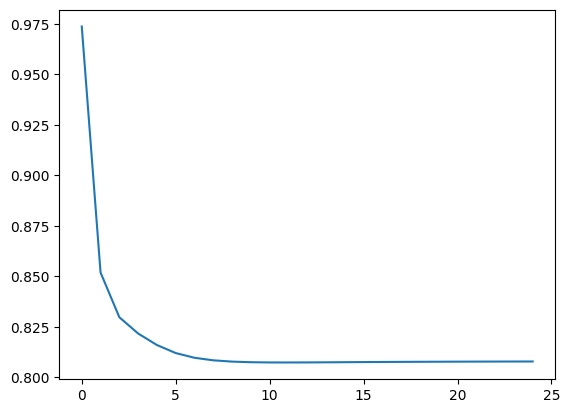

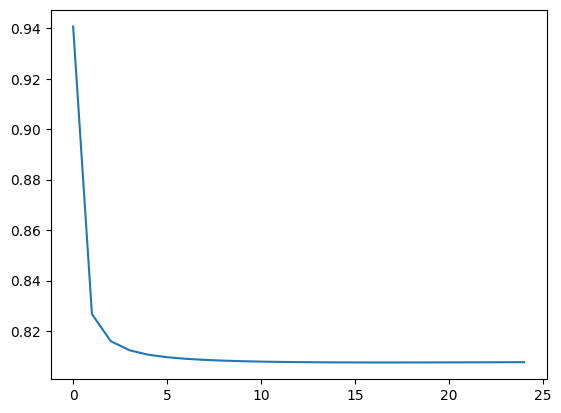

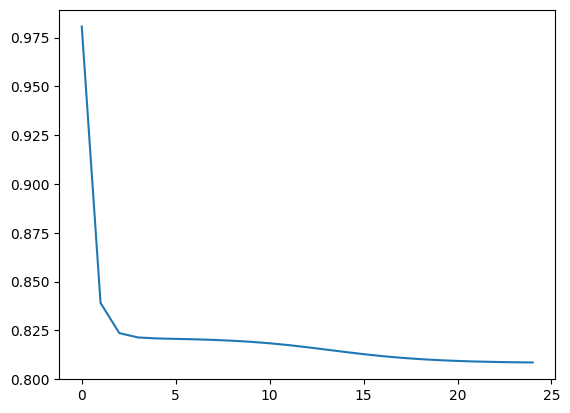

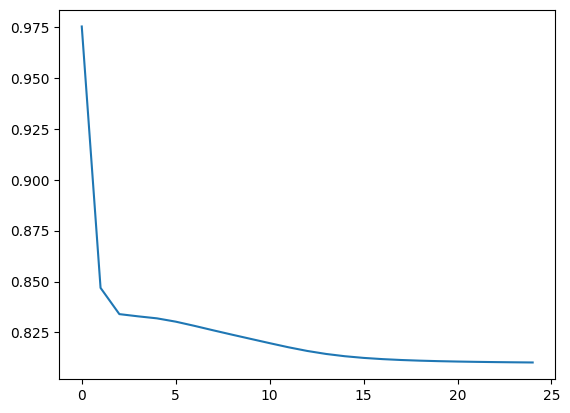

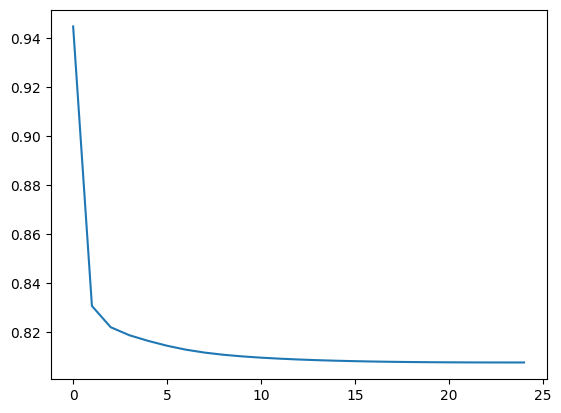

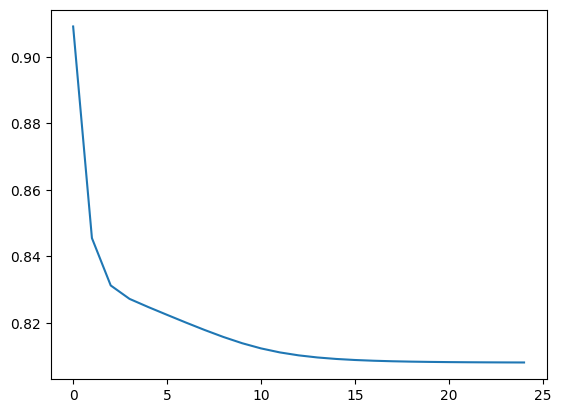

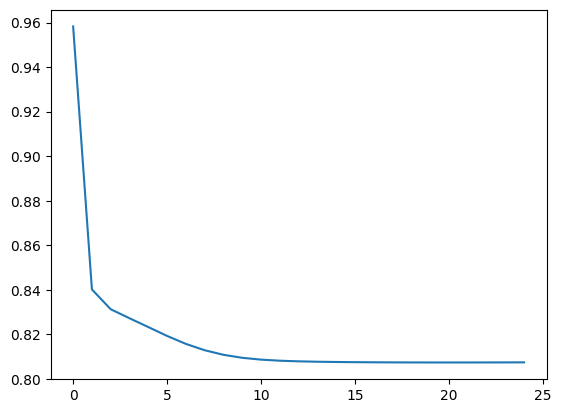

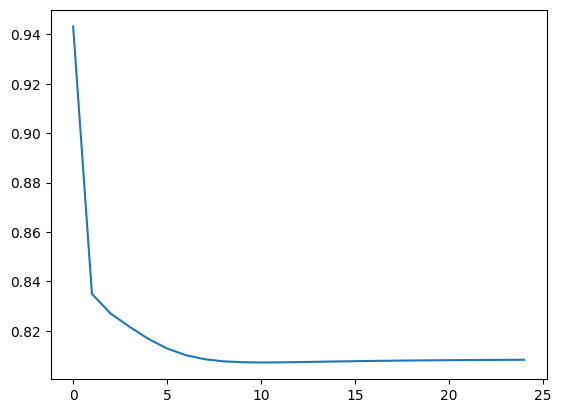

In [ ]:
test_multiple_embeding_dimensions(
    model_class=WalsRecommender,
    method=PredictionMethod.DOT,
    out_file="wals_model_results_final_dot.csv",
    epochs=[25],
    c=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    regularization_coefficient=[0.0, 0.00001, 0.0001, 0.001, 0.01]
)

In [6]:
test_multiple_embeding_dimensions(
    BPRRecommender,
    out_file="bpr_model_results.csv",
    epochs=[20*training_data.m*training_data.n],
    learning_rate=[0.00001, 0.00005, 0.0001, 0.001],
    regularization=[0., 0.0001, 0.001, 0.01],
)

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 4, 'regularization': 0.0001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.01560204407537528, 'recall_at_10': 0.06050501513663635, 'ndcg_at_10': 0.07683413537968624, 'precision_at_20': 0.011992973490897476, 'recall_at_20': 0.09067910772439934, 'ndcg_at_20': 0.09634989967193944, 'precision_at_50': 0.0079112104758863, 'recall_at_50': 0.14733022592714648, 'ndcg_at_50': 0.12541038111253533, 'precision_at_100': 0.00527946343021399, 'recall_at_100': 0.1978219117723097, 'ndcg_at_100': 0.1456379374612586}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 8, 'regularization': 0.001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.012791440434366017, 'recall_at_10': 0.048452527172814557, 'ndcg_at_10': 0.06212604210714955, 'precision_at_20': 0.010012775471095497, 'recall_at_20': 0.07689506441974149, 'ndcg_at_20': 0.07903656541040587, 'precision_at_50': 0.006547428936442032, 'recall_at_50': 0.12561008986844754, 'ndcg_at_50': 0.10273975134585815, 'precision_at_100': 0.004500159693388694, 'recall_at_100': 0.17281461717597588, 'ndcg_at_100': 0.12142186359861892}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 10, 'regularization': 0.001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.011992973490897476, 'recall_at_10': 0.04644692238371199, 'ndcg_at_10': 0.05802910032592288, 'precision_at_20': 0.009374001916320665, 'recall_at_20': 0.0721340954731668, 'ndcg_at_20': 0.07385875110489287, 'precision_at_50': 0.006055573299265411, 'recall_at_50': 0.11468008558455581, 'ndcg_at_50': 0.09530259678856781, 'precision_at_100': 0.004227083998722453, 'recall_at_100': 0.16112090162064058, 'ndcg_at_100': 0.1135609038916972}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 16, 'regularization': 0.0001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.010923027786649633, 'recall_at_10': 0.04140103153989063, 'ndcg_at_10': 0.05513784313726271, 'precision_at_20': 0.008312040881507506, 'recall_at_20': 0.0647656160113604, 'ndcg_at_20': 0.06839756124757733, 'precision_at_50': 0.005416799744490578, 'recall_at_50': 0.10646787811167806, 'ndcg_at_50': 0.08773154884648639, 'precision_at_100': 0.0039603960396039604, 'recall_at_100': 0.15611050618282554, 'ndcg_at_100': 0.10676608984315174}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

In [10]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.5, 'epochs': 1000, 'learning_rate': 100.0}

model = TopItemsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit()
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.04852325970978819
Precision 0.02400990099009901
Recall 0.1905249816378097
Normalized Discounted Cumulative Gain 0.1841149999164702


In [6]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1592.004     0.000000            0.0        0.0   
T1557.001     0.586885            0.0        0.0   
T1600         0.291803            0.0        0.0   
T1647         0.293443            0.0        0.0   
T1068         0.916393            0.0        0.0   
...                ...            ...        ...   
T1656         0.149180            0.0        0.0   
T1557.003     0.147541            0.0        0.0   
T1499.001     0.145902            0.0        0.0   
T1027.005     0.708197            0.0        0.0   
T1059.007     0.896721            0.0        0.0   

                                  technique_name  
T1592.004                  Client Configurations  
T1557.001   LLMNR/NBT-NS Poisoning and SMB Relay  
T1600                          Weaken Encryption  
T1647                    Plist File Modification  
T1068      Exploitation for Privilege Escalation  
...                                          ...  
T1656             

In [14]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.001, 'epochs': 10, 'learning_rate': 1.0}

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_validation(
#     learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
#     epochs=[1000],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
#     gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)


Mean Squared Error 8.200210708280245
Precision 0.0014993585631815267
Recall 0.018532725776008053
Normalized Discounted Cumulative Gain 0.00973503731752359


In [17]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

            predictions  training_data  test_data  \
T1204.002 -44127.687500            0.0        0.0   
T1592.001 -18382.687500            0.0        0.0   
T1547.012  43962.042969            0.0        0.0   
T1561.002  46403.843750            0.0        0.0   
T1110.004  67053.593750            0.0        0.0   
...                 ...            ...        ...   
T1612      34722.996094            0.0        0.0   
T1588.006 -39228.710938            0.0        0.0   
T1003     -42823.429688            0.0        0.0   
T1069.002 -36731.289062            0.0        0.0   
T1070.005  12406.809570            0.0        0.0   

                             technique_name  
T1204.002                    Malicious File  
T1592.001                          Hardware  
T1547.012                  Print Processors  
T1561.002               Disk Structure Wipe  
T1110.004               Credential Stuffing  
...                                     ...  
T1612                   Build Image on Ho

In [20]:
# hyperparameters
embedding_dimension = 4
k = 20
best_hyperparameters = {'regularization_coefficient': 0.0001, 'epochs': 2, 'learning_rate': 0.0001}
# best_hyperparameters["epochs"] = 20*training_data.m*training_data.n

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     epochs=[500 * 512],
#     regularization_coefficient=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

KeyboardInterrupt: 

In [17]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1558.002     0.555484            0.0        0.0   
T1132.002     0.494036            0.0        0.0   
T1211        -0.492932            0.0        0.0   
T1601.002    -0.185998            0.0        0.0   
T1596        -0.025210            0.0        0.0   
...                ...            ...        ...   
T1546.011    -0.217676            0.0        0.0   
T1535         0.464719            0.0        0.0   
T1071         0.199836            0.0        0.0   
T1587         0.658772            0.0        0.0   
T1499.002     0.464182            0.0        0.0   

                             technique_name  
T1558.002                     Silver Ticket  
T1132.002             Non-Standard Encoding  
T1211      Exploitation for Defense Evasion  
T1601.002            Downgrade System Image  
T1596       Search Open Technical Databases  
...                                     ...  
T1546.011              Application Shimming  
T1535  

In [22]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization_coefficient': 0.0001, "epochs": 20, 'learning_rate': 0.005}

model = ImplicitBPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     epochs=[math.floor(500 * 512 / training_data.to_numpy().sum())],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

100%|██████████| 20/20 [00:00<00:00, 261.94it/s, train_auc=51.95%, skipped=9.34%]


Mean Squared Error 0.8416396221072098
Precision 0.008555163566388711
Recall 0.1188407602595878
Normalized Discounted Cumulative Gain 0.05200668172568438


In [23]:
# hyperparameters
embedding_dimension = 10
k = 20

best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'epochs': 20}

model = ImplicitWalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_validation(
#     epochs=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

100%|██████████| 20/20 [00:00<00:00, 51.99it/s]


Mean Squared Error 0.5028757316475128
Precision 0.008659397049390635
Recall 0.11683780275644119
Normalized Discounted Cumulative Gain 0.06099917717388372


In [25]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1204.002     0.190945            0.0        0.0   
T1592.001    -0.088588            0.0        0.0   
T1547.012     0.595495            0.0        0.0   
T1561.002     0.591824            0.0        0.0   
T1110.004    -0.004705            0.0        0.0   
...                ...            ...        ...   
T1612         0.140598            0.0        0.0   
T1588.006     0.665867            0.0        0.0   
T1003        -0.068861            0.0        0.0   
T1069.002     0.364830            0.0        0.0   
T1070.005     0.198465            0.0        0.0   

                             technique_name  
T1204.002                    Malicious File  
T1592.001                          Hardware  
T1547.012                  Print Processors  
T1561.002               Disk Structure Wipe  
T1110.004               Credential Stuffing  
...                                     ...  
T1612                   Build Image on Host  
T1588.0

In [27]:
# hyperparameters
embedding_dimension = 4
k = 20

# best_hyperparameters = {'regularization_coefficient': 0.1, 'c': 0.5, 'epochs': 20}
# best_hyperparameters = {'regularization_coefficient': 0.0001, 'c': 0.3, 'epochs': 100}
best_hyperparameters = {'regularization_coefficient': 0.001, 'c': 0.1, "epochs": 20}
model = WalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_validation(
#     epochs=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.22009765631062408
Precision 0.0081783194355356
Recall 0.11611657887235578
Normalized Discounted Cumulative Gain 0.05730162211191529


In [28]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1204.002     0.746440            0.0        0.0   
T1592.001    -0.030477            0.0        0.0   
T1547.012     0.976308            0.0        0.0   
T1561.002     0.676964            0.0        0.0   
T1110.004     0.389903            0.0        0.0   
...                ...            ...        ...   
T1612         0.093252            0.0        0.0   
T1588.006     0.731710            0.0        0.0   
T1003        -0.059756            0.0        0.0   
T1069.002     0.502788            0.0        0.0   
T1070.005     0.731683            0.0        0.0   

                             technique_name  
T1204.002                    Malicious File  
T1592.001                          Hardware  
T1547.012                  Print Processors  
T1561.002               Disk Structure Wipe  
T1110.004               Credential Stuffing  
...                                     ...  
T1612                   Build Image on Host  
T1588.0

In [18]:
# TEMPORARY - GET EMBEDDINGS FOR FE
U = tie.get_U() # entity (report) ids
V = tie.get_V() # item (technique) embeddings

U_with_index = np.hstack((np.expand_dims(training_data.report_ids, axis=1), U))
V_with_index = np.hstack((np.expand_dims(training_data.technique_ids, axis=1), V))

print(U_with_index.shape)
print(V_with_index.shape)

[[ 0.00000000e+00  3.10272485e-01 -5.06079257e-01 ... -2.96728946e-02
   1.03696346e-01 -4.59698914e-03]
 [ 1.00000000e+00  2.34661356e-01 -3.45782340e-01 ... -8.81108269e-02
   7.32592419e-02  2.15996355e-01]
 [ 2.00000000e+00  4.81936446e-08  6.88791080e-10 ...  3.42836657e-08
  -7.81015075e-09 -4.81467985e-08]
 ...
 [ 6.25900000e+03  3.53572398e-01 -4.88738894e-01 ...  2.14364976e-02
   1.39371127e-01  1.01979606e-01]
 [ 6.26000000e+03 -5.61978075e-10 -3.23640350e-08 ... -7.43976116e-08
   8.64229861e-08  8.77083117e-09]
 [ 6.26100000e+03 -6.00948269e-08 -1.48262300e-08 ...  3.57593208e-08
  -9.07301079e-09  2.34565452e-08]]
(6262, 11)
(611, 11)


recalls [0.3087573406401257, 0.3257859760812914, 0.3458226653670225, 0.3745375233589626, 0.3949941633991787, 0.4110964558541681, 0.4219309973671012, 0.4317147374599419, 0.44042389049516534, 0.44770298702149547, 0.45387773687027355, 0.45797033624322875, 0.46304119765720547, 0.4679221448741617, 0.47182791494477766, 0.47617333685846847, 0.4791363202775644, 0.48264413250862803, 0.48577394889957126, 0.4883141430997783, 0.4904385260449852]


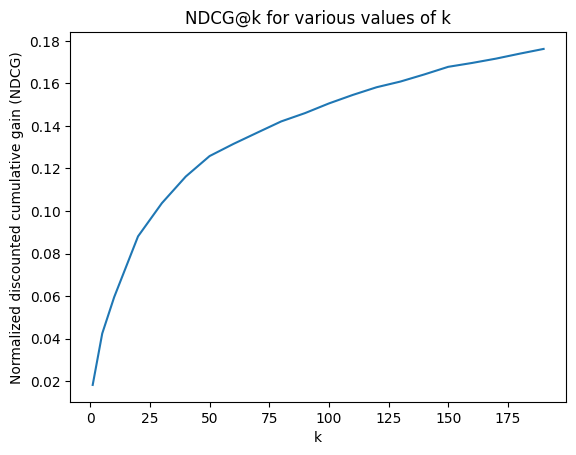

In [8]:
k_values = [1, 5] + list(range(10, 200, 10))
recalls = []
ndcgs = []
for k in k_values:
    # print("Mean Squared Error", mse)
    precision = tie.precision(k=k)
    # print("Precision", precision)
    recall = tie.recall(k=k)
    recalls.append(recall)
    # print("Recall", recall)
    ndcg = tie.normalized_discounted_cumulative_gain(k=k)
    ndcgs.append(ndcg)
    # print("Normalized Discounted Cumulative Gain", ndcg)

print("recalls", recalls)

plt.xlabel("k")
plt.ylabel("Normalized discounted cumulative gain (NDCG)")
plt.title("NDCG@k for various values of k")
plt.plot(k_values, ndcgs)

In [6]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, c=0.5, regularization_coefficient=0.05, learning_rate=0.01, epochs=100)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

TypeError: FactorizationRecommender.predict_new_entity() got an unexpected keyword argument 'c'

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 6262 samples in 0.003s...
[t-SNE] Computed neighbors for 6262 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6262
[t-SNE] Computed conditional probabilities for sample 2000 / 6262
[t-SNE] Computed conditional probabilities for sample 3000 / 6262
[t-SNE] Computed conditional probabilities for sample 4000 / 6262
[t-SNE] Computed conditional probabilities for sample 5000 / 6262
[t-SNE] Computed conditional probabilities for sample 6000 / 6262
[t-SNE] Computed conditional probabilities for sample 6262 / 6262
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.187531
[t-SNE] KL divergence after 10000 iterations: 0.847868


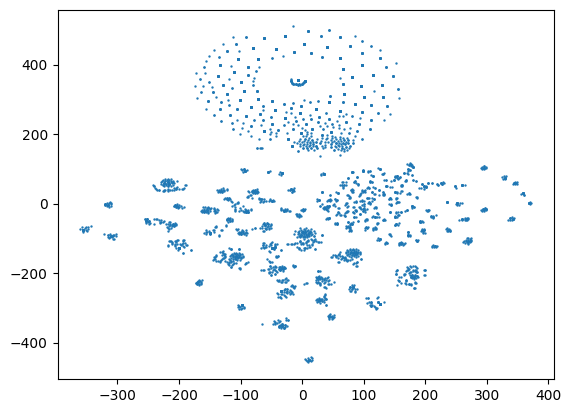

In [11]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=15,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()